# Built-up area extraction

Import required packages

In [8]:
import numpy as np
import os
from osgeo import gdal
from sklearn.ensemble import RandomForestClassifier
from scipy.misc import imsave
from scipy.cluster.vq import *
import csv
import cv2
from skimage.segmentation import slic
from skimage.feature import greycomatrix, greycoprops
from skimage.util import img_as_float

Setting file paths

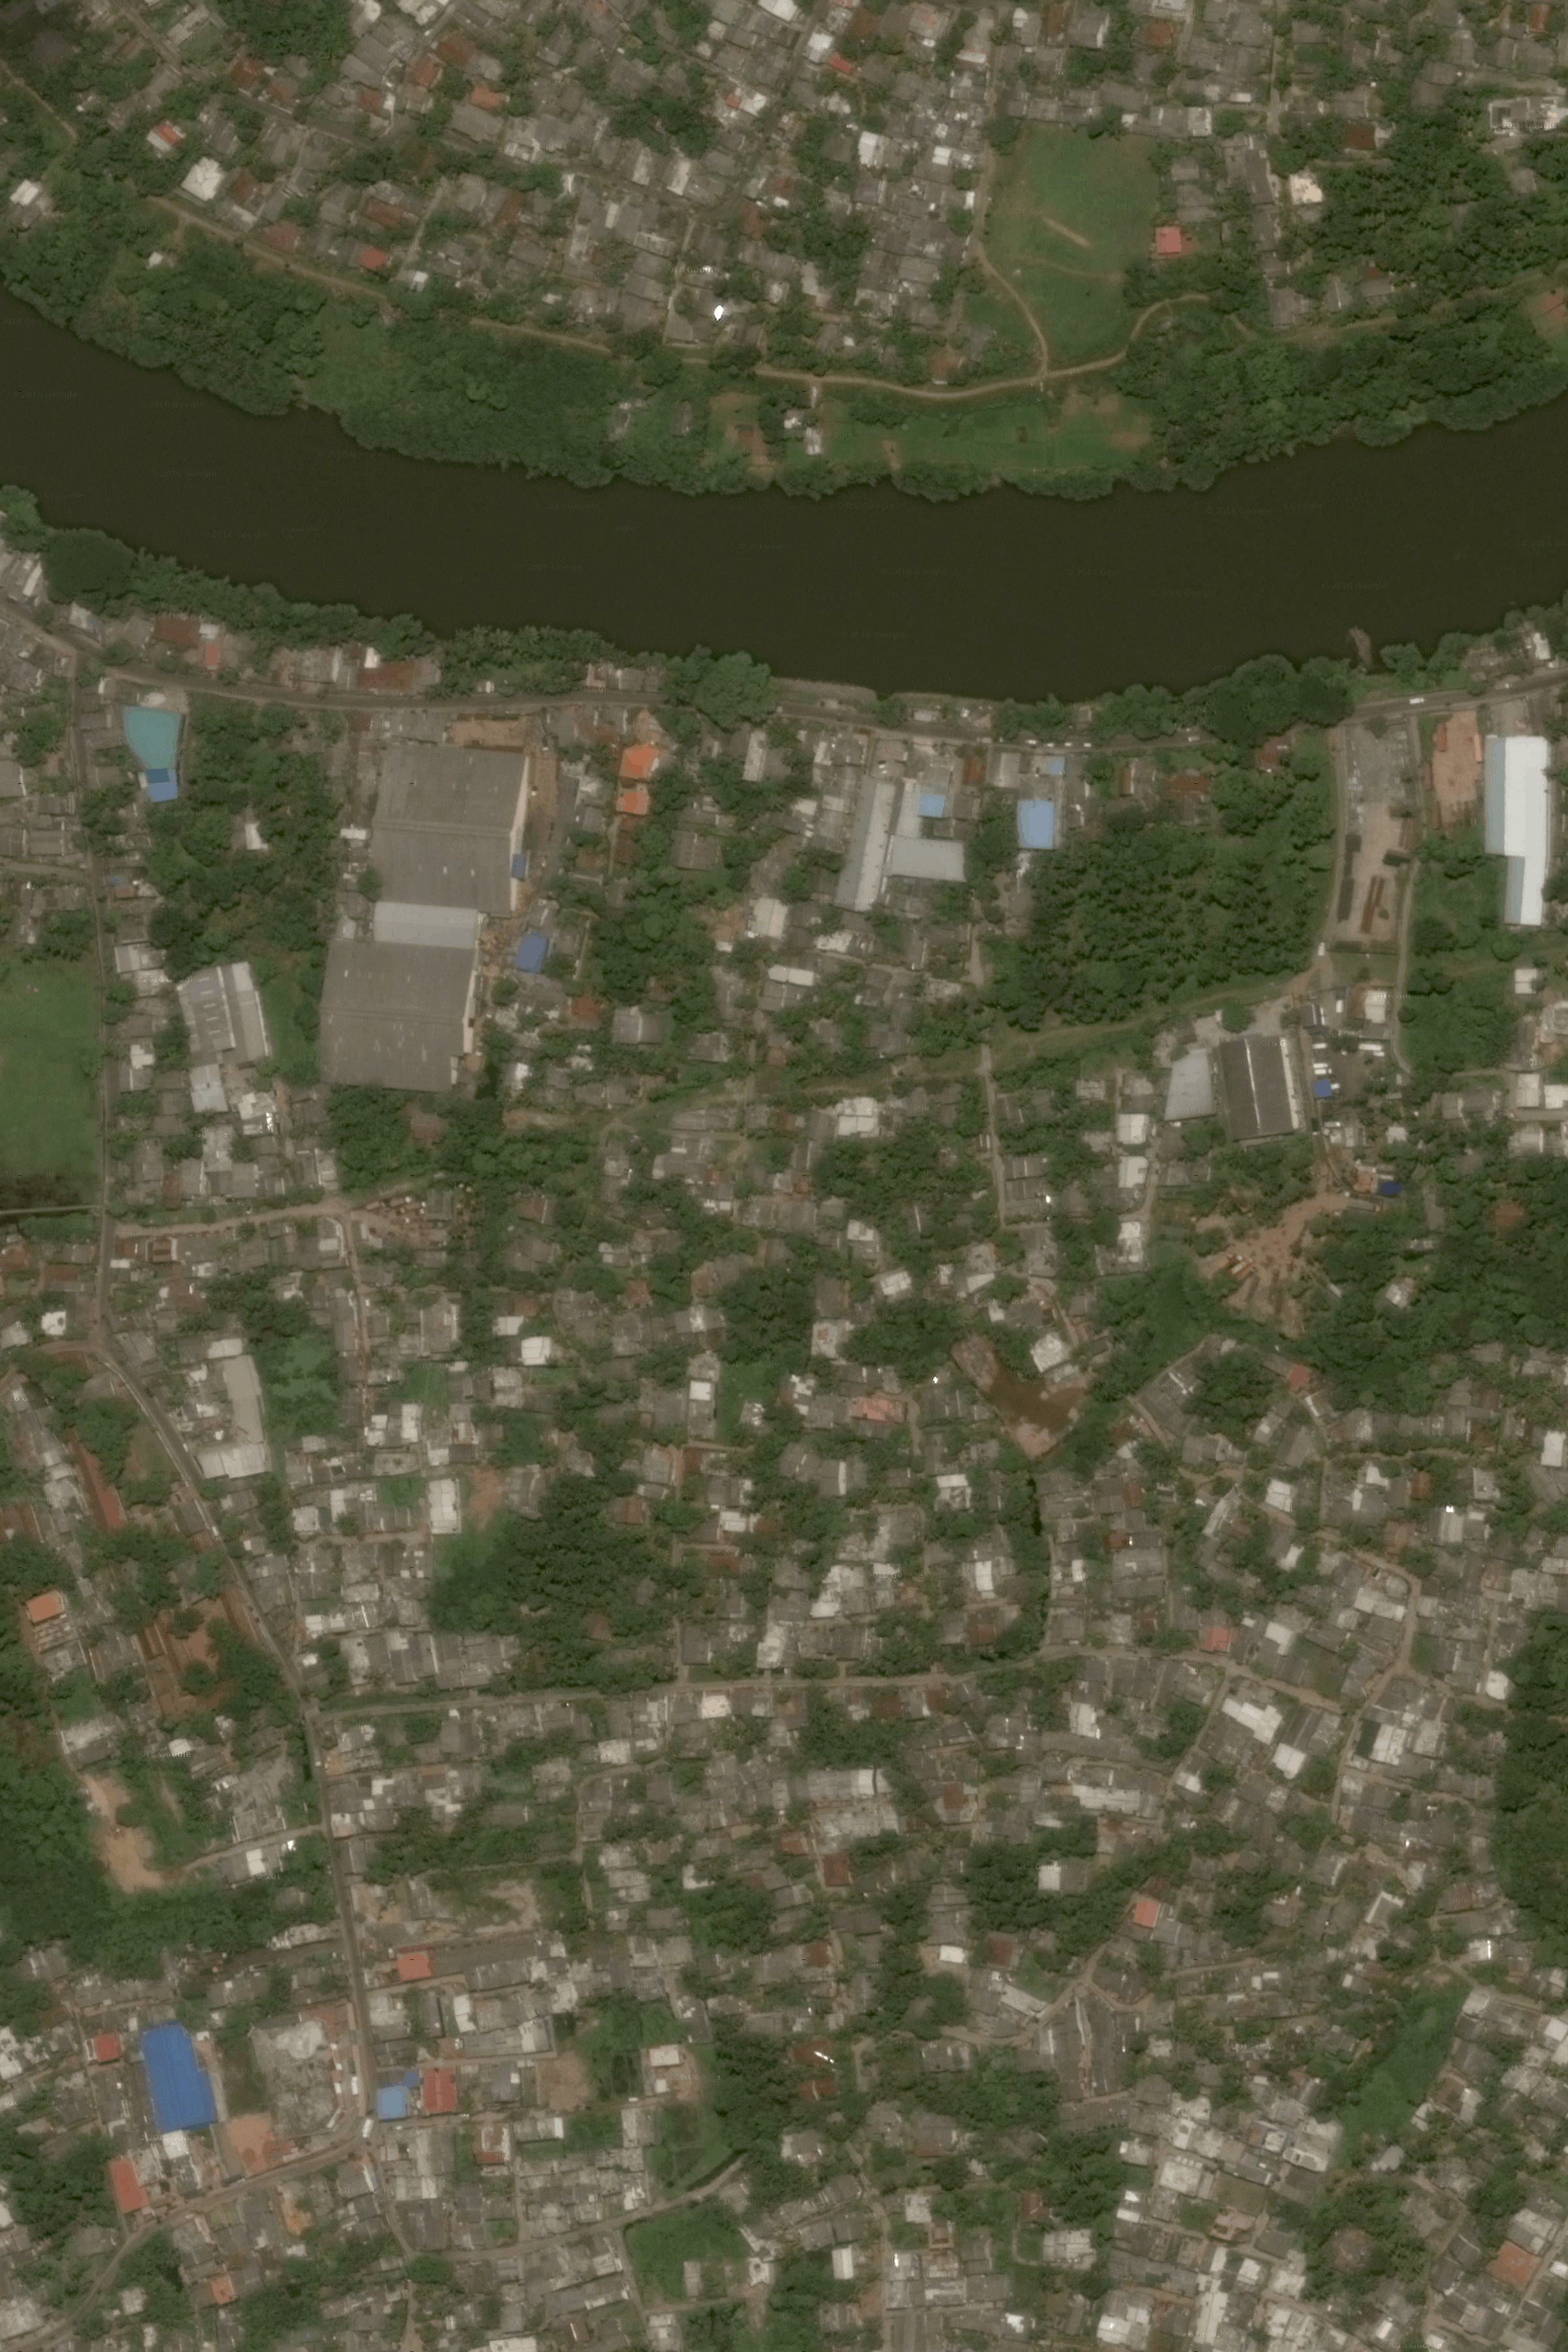

In [6]:
# Path to input images
input_raster = "new.jpg"
# Path to training folder of per-pixel classification
path = "/TrainSamples"
# Path to csv file with training data for object based classification
path_toCSV = "train.csv"
# Path to save image segments
path_segments = "/segments"
# Path to save builtup areas of images
path_builtup = "/builtupAreas"

# Display original image
from IPython.display import Image as img
img(filename='input.jpg', width=250, height=250)

In order to extract building and road pixels from the rest of the image, supervised per-pixel classification is used. Here two classes of training samples are prepared. Class I includes building and road pixels and class II includes vegetation and water pixels. A random forest classifier is trained using the prepared training samples. 

In [7]:
def rasterizeVector(path_to_vector, cols, rows, geo_transform, projection):
    lblRaster = np.zeros((rows, cols))
    for i, path in enumerate(path_to_vector):
        label = i + 1
        # open the input datasource and read content
        inputDS = gdal.OpenEx(path, gdal.OF_VECTOR)
        shpLayer = inputDS.GetLayer(0)
        # Create the destination data source
        driver = gdal.GetDriverByName('MEM')
        rasterDS = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
        # Define spatial reference
        rasterDS.SetGeoTransform(geo_transform)
        rasterDS.SetProjection(projection)
        # Rasterize
        gdal.RasterizeLayer(rasterDS, [1], shpLayer, burn_values=[label])
        # Get a raster band
        rBand = rasterDS.GetRasterBand(1)
        lblRaster += rBand.ReadAsArray()
        rasterDS = None
    return lblRaster

# ----------Supervised per-pixel classification -----------------------------
trainingData = []
trainingLabels = []
if len(path) > 0:
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg'):
                inpRaster = ""
                shapefiles = ""
                inpRaster = os.path.join(subdir, file)
                # Open raster dataset
                rasterDS = gdal.Open(inpRaster, gdal.GA_ReadOnly)
                # Get spatial reference
                geo_transform = rasterDS.GetGeoTransform()
                projection = rasterDS.GetProjectionRef()

                # Extract band's data and transform into a numpy array
                bandsData = []
                for b in range(1, rasterDS.RasterCount + 1):
                    band = rasterDS.GetRasterBand(b)
                    bandsData.append(band.ReadAsArray())
                bandsData = np.dstack(bandsData)
                rows, cols, noBands = bandsData.shape

                # Read vector data, and rasterize all the vectors in the given directory into a single labelled raster
                files = [f for f in os.listdir(subdir) if f.endswith('.shp')]
                classes = [f.split('.')[0] for f in files]
                shapefiles = [os.path.join(subdir, f) for f in files if f.endswith('.shp')]
                lblRaster = rasterizeVector(shapefiles, rows, cols, geo_transform, projection)

                # Prepare training data (set of pixels used for training) and labels
                isTrain = np.nonzero(lblRaster)
                trainingLabels.append(lblRaster[isTrain])
                trainingData.append(bandsData[isTrain])

trainingData = np.vstack(trainingData)
trainingLabels = np.hstack(trainingLabels)
classifier = RandomForestClassifier(n_jobs=4, n_estimators=10)
classifier.fit(trainingData, trainingLabels)

ValueError: need at least one array to concatenate

Prior to segmentation, K-means clustering is used to cluster the images into a set of homogeneous clusters since this was observed to increase the homogeneity of the segments produced by the super pixel based segmentation technique.


In [4]:
# ----------------------Clustering original image with kmeans-------------------------------

# Opening GDAL supported raster datastore

input_dataset = gdal.Open(input_raster, gdal.GA_ReadOnly)

# Loop through all raster bands
bands_dataset = []
for b in range(1, input_dataset.RasterCount + 1):
    band = input_dataset.GetRasterBand(b)
    bands_dataset.append(band.ReadAsArray())

# Stack 2D arrays (image) into a single 3D array
stack = np.dstack(bands_dataset)

# Get the dimensions of 'stack' in (no. of rows, no. of columns, no. of bands) format
rows, cols, n_bands = stack.shape

# Total number of data samples in stack
n_samples = rows * cols

# Flatten stack to rows
stack_flat = stack.reshape((n_samples, n_bands))

# Apply k-means clustering
n_clusters = 4
centroids, variance = kmeans(stack_flat, n_clusters)
code, distance = vq(stack_flat, centroids)
cluster_img = code.reshape(stack.shape[0], stack.shape[1])

# Save clustered image
imsave('kmeans.tif', cluster_img)

# Display clustered image
from IPython.display import Image as img
img(filename='kmeans.png', width=250, height=250)

AttributeError: 'NoneType' object has no attribute 'RasterCount'

Use the previously trained random forest classifier to classify the input satellite image. 

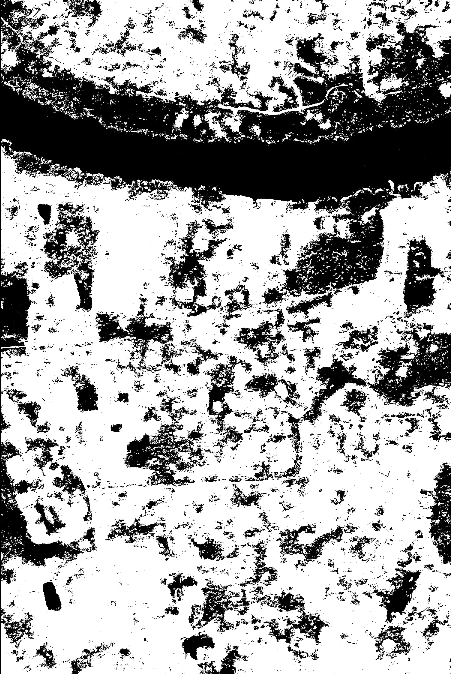

In [5]:
rasterDS = gdal.Open(input_raster, gdal.GA_ReadOnly)

# Extract band's data and transform into a numpy array
bandsData = []
for b in range(1, rasterDS.RasterCount + 1):
    band = rasterDS.GetRasterBand(b)
    bandsData.append(band.ReadAsArray())
bandsData = np.dstack(bandsData)
rows, cols, noBands = bandsData.shape

noSamples = rows * cols
flat_pixels = bandsData.reshape((noSamples, noBands))

result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

imsave("classified.tif", classification)

# Display classified image
from IPython.display import Image as img
img(filename='classified.png', width=250, height=250)

Using the classified image, prepare a mask which contains only the water and vegetation pixels (class II pixels). Afterwards, use this mask to mask out the clustered image (see above) and thereby isolate the building and road pixels (class I pixels) in it.

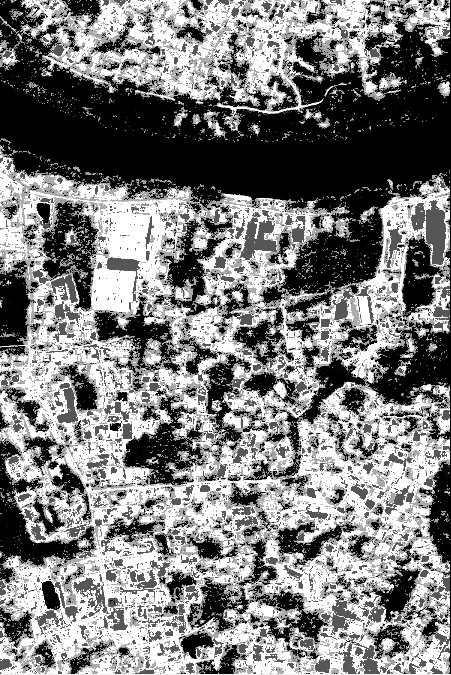

In [6]:
vegetationImg = cv2.imread("classified.tif");
img2gray = cv2.cvtColor(vegetationImg, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
image = cv2.imread('kmeans.tif')
output = cv2.bitwise_and(image, image, mask=mask)
imsave("masked.tif", output)

# Display masked image
from IPython.display import Image as img
img(filename='masked.png', width=250, height=250)

Train a random forest classifier for object based classification. (See train.py)

In [7]:
sample = []
data = []
labels = []
with open(path_toCSV) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        sample.append(row['contrast'])
        sample.append(row['dissimilarity'])
        sample.append(row['homogeneity'])
        sample.append(row['energy'])
        sample.append(row['correlation'])
        sample.append(row['ASM'])
        data.append(sample)
        labels.append(row['class'])
        sample = []

classifier_stageII = RandomForestClassifier(n_jobs=4, n_estimators=10)
classifier_stageII.fit(data, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Segment the image containing road and building pixels using SLIC.

In [8]:
img = cv2.imread("masked.tif")

# load the image and convert it to a floating point data type
image = img_as_float(img)

# loop over the number of segments
for numSegments in (1, 4):
    # apply SLIC and extract (approximately) the supplied number
    # of segments
    segments = slic(image, n_segments=numSegments, compactness=10, sigma=5, max_iter=4)

# loop over the unique segment values
for (i, segVal) in enumerate(np.unique(segments)):
    # construct a mask for the segment
    "[x] inspecting segment %d" % (i)
    mask = np.zeros(image.shape[:2], dtype="uint8")
    mask[segments == segVal] = 255

    applied = cv2.bitwise_and(image, image, mask=mask)
    name = path_segments + "/segment{0}.tif".format(str(i))
    imsave(name, applied)

Classify the segments with previously trained random forest classifier. (classifier_stageII)

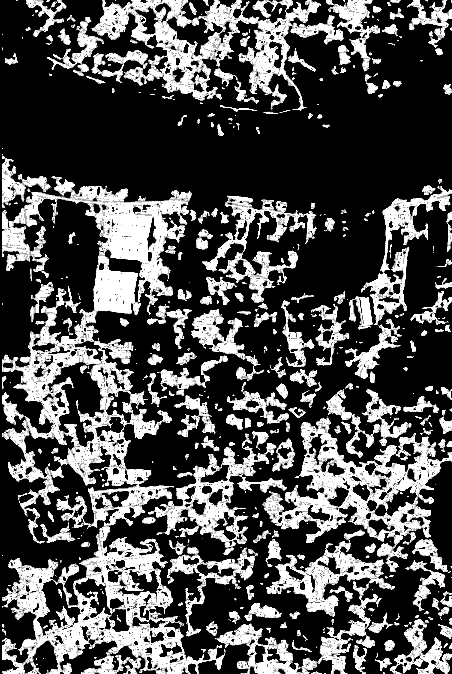

In [9]:
for file in os.listdir(path_segments):
    if file.endswith('.tif'):
        filename = path_segments + '/' + file
        img = cv2.imread(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        glcm = greycomatrix(gray, [1], [0], symmetric=True, normed=True)
        sample = []
        sample.append(greycoprops(glcm, 'contrast')[0][0])
        sample.append(greycoprops(glcm, 'dissimilarity')[0][0])
        sample.append(greycoprops(glcm, 'homogeneity')[0][0])
        sample.append(greycoprops(glcm, 'energy')[0][0])
        sample.append(greycoprops(glcm, 'correlation')[0][0])
        sample.append(greycoprops(glcm, 'ASM')[0][0])
        prediction = classifier_stageII.predict([sample])
        if(prediction == "Buildings"):
            imsave("builtup.tif", img)
            
# Display identified built up areas in the input image
from IPython.display import Image as img
img(filename='builtup.png', width=250, height=250)